In [1]:
import candas as can
import pathlib as pl
import numpy as np
from scipy import stats
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

from candas.test import QuantStudio

import gumbi as gmb


In [2]:
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

fig_num = 1
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

## Global Figure Parameters

In [3]:

width = 1.625/2
height = 1.65/2
figsize=(width, height)
spotsize=8**2
linewidth=2
ticklabelsize=8
labelsize=10
titlesize=labelsize+2

radar_figsize = (1.25, 1.25)
radar_spotsize = 8

disease, healthy = hex_color, fam_color = sns.diverging_palette(20, 220, s=100, n=2)
palette = sns.diverging_palette(20, 220, as_cmap=True)

def format_ax(
    ax,
    figsize=figsize,
    mar_l=0.56,
    mar_r=0.17,
    mar_t=0.22,
    mar_b=0.48,
    ticklabelsize=ticklabelsize,
    labelsize=labelsize,
    titlesize=titlesize,
    **kwargs
):
    width, height = figsize
    
    ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize)
    ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize)
    ax.set_title(ax.get_title(), fontsize=titlesize)

    ax.tick_params(axis="both", length=1, width=0.5, labelsize=ticklabelsize)
    
    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )
    plt.setp(ax.spines.values(), linewidth=0.5)

    return ax

def savefig(fig, title):
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')


# Radar Plots

## Plotting functions

In [4]:
def symmetrize(x):
    return np.hstack([x, x[:, ::-1]])[:,::2]

def circularize(x):
    return np.hstack([x, x[:, 0].reshape(-1, 1)])

In [5]:
def find_centroid(rs, label_loc):
    rs = np.expand_dims(rs, axis=-1) if len(rs.shape) == 2 else rs
    θs = np.expand_dims(label_loc, axis=(0,2))
    
    # Convert from polar to cartesian coordinates
    xy = np.stack([np.cos(θs)*rs, np.sin(θs)*rs], axis=-1)
    x = np.cos(θs)*rs
    y = np.sin(θs)*rs
    
    # Centroid of a polygon
    A = 1/2 * np.sum(np.cross(xy[:, :-1], xy[:, 1:]), axis=1, keepdims=True) 
    Cx = 1/(6*A) * np.sum((xy[:, :-1, :, 0] + xy[:, 1:, :, 0]) * np.cross(xy[:, :-1, ...], xy[:, 1:, ...]), axis=1, keepdims=True)
    Cy = 1/(6*A) * np.sum((xy[:, :-1, :, 1] + xy[:, 1:, :, 1]) * np.cross(xy[:, :-1, ...], xy[:, 1:, ...]), axis=1, keepdims=True)
    
    centroid_r = np.sqrt(Cx**2 + Cy**2)
    centroid_θ = np.arctan2(Cy, Cx) % (2*np.pi)
    
    return centroid_θ, centroid_r

In [6]:
def prepare_radar_plot(label_loc, labels, r_max=6, figsize=None):
    figsize = figsize or (1.1, 1.1)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(polar=True)

    _ = ax.set_thetagrids(np.degrees(label_loc), labels=labels)
    ax.set_yticklabels([])
    ax.set_ylim(0, r_max)
    ax.set_yticks(np.arange(r_max+1))
    ax.set_theta_zero_location("N")
    
    return fig, ax

def rotate_radar_labels(ax, ticklabelsize=ticklabelsize, y_offset=0):
    angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())) % (2*np.pi)
    angles = np.rad2deg(angles)
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x,y = label.get_position()
        lab = ax.text(x,y+y_offset, 'RNA '+label.get_text(),
                      fontsize=ticklabelsize,
                      transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va(),
                    #   bbox={'pad':0.01}
                      )
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])
    return labels

## Synthetic Populations

In [7]:
indiv_lw = 0.5
indiv_fill_alpha = 0.1
indiv_cent_alpha = 0.5
pop_lw = 1
pop_fill_alpha = 0.5
cent_ms = 4

In [8]:
SEED = 1
n_genes = 5
n_patients = 5
r_max = 6

# Averages for lognormal distribution
locs = np.arange(n_genes)
locs = np.vstack([locs, locs+stats.norm(-1, 1).rvs(n_genes, random_state=SEED)])

# Generate a range of population averages for each gene
pop_avgs = stats.lognorm(loc=locs, s=1.2).rvs([2, n_genes], random_state=SEED)

# Inversely sort each condition
pop_avgs = np.sort(pop_avgs, axis=1)
pop_avgs[1, :] = pop_avgs[1, ::-1]

# Symmetrize and circularize to define the final population averages
pop_avgs = circularize(symmetrize(pop_avgs))

# Rescale averages values to [0, 5]
pop_avgs = pop_avgs / pop_avgs.max() * (r_max-1)

labels = np.arange(n_genes)+1
labels = [*labels, labels[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=n_genes+1)

# Draw samples from each population average and circularize
scales = stats.uniform(0.2, 0.5).rvs([1, n_genes], random_state=SEED)

samples = stats.lognorm(loc=pop_avgs[:, :-1]-1, s=scales).rvs([n_patients, 2, n_genes], random_state=SEED)
samples = np.moveaxis(samples, 0, -1)
samples = np.concatenate([samples, samples[:, [0], :]], axis=1)

## Disease patients

Saving Fig_1_A_i in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


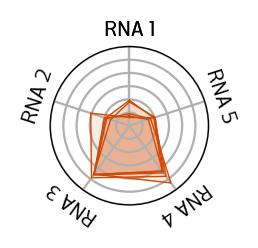

In [9]:
fig, ax = prepare_radar_plot(label_loc, labels)

# Individual samples
ax.plot(label_loc, samples[0, ...], 
        color=disease, lw=indiv_lw, 
        # marker='o', ms=5
        )
for sample in samples[0, ...].T:
    ax.fill(label_loc, sample, lw=0, color=disease, alpha=indiv_fill_alpha)

# Individual sample centroids
# centroid_θ, centroid_r = find_centroid(samples, label_loc)
# ax.plot(centroid_θ[0, :], centroid_r[0, :], 'o', ms=cent_ms, color=disease, alpha=indiv_cent_alpha)

rotate_radar_labels(ax, y_offset=0.2);
format_ax(ax, figsize=radar_figsize, 
        mar_l=0.175,
        mar_r=0.175,
        mar_t=0.175,
        mar_b=0.175, 
        ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'A'
subpanel = 'i'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')


## Healthy patients

Saving Fig_1_A_ii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


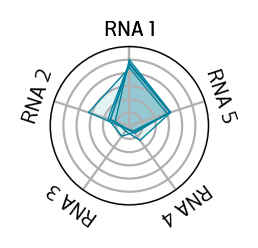

In [10]:
fig, ax = prepare_radar_plot(label_loc, labels)

# Individual samples
ax.plot(label_loc, samples[1, ...], 
        color=healthy, lw=indiv_lw, 
        # marker='o', ms=5
        )
for sample in samples[1, ...].T:
    ax.fill(label_loc, sample, lw=0, color=healthy, alpha=indiv_fill_alpha)

# Individual sample centroids
# centroid_θ, centroid_r = find_centroid(samples, label_loc)
# ax.plot(centroid_θ[1, :], centroid_r[1, :], 'o', ms=cent_ms, color=healthy, alpha=indiv_cent_alpha)

rotate_radar_labels(ax, y_offset=0.2);
format_ax(ax, figsize=radar_figsize, 
        mar_l=0.175,
        mar_r=0.175,
        mar_t=0.175,
        mar_b=0.175, 
        ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'A'
subpanel = 'ii'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

## Population plots

Saving Fig_1_A_iii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


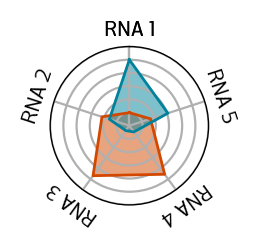

In [11]:
fig, ax = prepare_radar_plot(label_loc, labels)

ax.plot(label_loc, pop_avgs[0, :], color=disease, lw=pop_lw)
# ax.plot(label_loc, samples[0, :, :5], color=healthy, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[0, :], lw=0, color=disease, alpha=pop_fill_alpha)

ax.plot(label_loc, pop_avgs[1, :], color=healthy, lw=pop_lw)
# ax.plot(label_loc, samples[1, :, :5], color=disease, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[1, :], lw=0, color=healthy, alpha=pop_fill_alpha)

# Find population centroids
# centroid_θ, centroid_r = find_centroid(pop_avgs, label_loc)
# ax.plot(centroid_θ[0], centroid_r[0], 'o', color=disease, ms=cent_ms)
# ax.plot(centroid_θ[1], centroid_r[1], 'o', color=healthy, ms=cent_ms)

rotate_radar_labels(ax, y_offset=0.2);
format_ax(ax, figsize=radar_figsize, 
        mar_l=0.175,
        mar_r=0.175,
        mar_t=0.175,
        mar_b=0.175, 
        ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'A'
subpanel = 'iii'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

## Signature specification by competitors

Saving Fig_1_A_iv in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


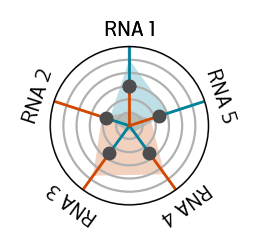

In [12]:
fig, ax = prepare_radar_plot(label_loc, labels)

# Re-plot population averages
# ax.plot(label_loc, pop_avgs[0, :], color=disease, lw=pop_lw/2)
# ax.plot(label_loc, samples[0, :, :5], color=healthy, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[0, :], lw=0, color=disease, alpha=pop_fill_alpha/2)

# ax.plot(label_loc, pop_avgs[1, :], color=healthy, lw=pop_lw/2)
# ax.plot(label_loc, samples[1, :, :5], color=disease, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[1, :], lw=0, color=healthy, alpha=pop_fill_alpha/2)

# Indicate reference oligo concentrations
refs = pop_avgs.mean(0)
# ax.plot(np.tile(label_loc, (2,1)), pop_avgs, color='0.3', lw=pop_lw)
# ax.plot(np.tile(label_loc, (2,1)), pop_avgs, color='0.3', lw=pop_lw)


for loc, ref, avgs in zip(label_loc[:-1], refs, pop_avgs.T):
    inner = [0, ref]
    outer = [ref, r_max]
    inner_is_disease = (avgs[0]>avgs[1]).astype(int)
    inner_color = [disease, healthy][inner_is_disease]
    outer_color = [disease, healthy][~inner_is_disease]
    ax.plot([loc, loc], inner, color=inner_color, lw=1)
    ax.plot([loc, loc], outer, color=outer_color, lw=1)
    
    
ax.plot(label_loc, refs, color='0.3', ls='none', marker='o', ms=cent_ms)


rotate_radar_labels(ax, y_offset=0.2);
format_ax(ax, figsize=radar_figsize, 
        mar_l=0.175,
        mar_r=0.175,
        mar_t=0.175,
        mar_b=0.175, 
        ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'A'
subpanel = 'iv'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

## New patient assessment

Saving Fig_1_A_v in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


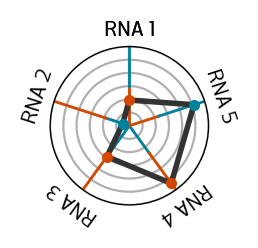

In [13]:
new_patient_coeff = stats.uniform(0.5, 1.5).rvs([1, n_genes], random_state=SEED+1)
new_patient = new_patient_coeff*np.roll(pop_avgs[0,:-1],1)
new_patient = circularize(new_patient).squeeze()

fig, ax = prepare_radar_plot(label_loc, labels)


# ax.fill(label_loc, pop_avgs[0, :], lw=0, color=disease, alpha=pop_fill_alpha/2)
# ax.fill(label_loc, pop_avgs[1, :], lw=0, color=healthy, alpha=pop_fill_alpha/2)

for loc, ref, avgs in zip(label_loc[:-1], refs, pop_avgs.T):
    inner = [0, ref]
    outer = [ref, r_max]
    inner_is_disease = (avgs[0]>avgs[1]).astype(int)
    inner_color = [disease, healthy][inner_is_disease]
    outer_color = [disease, healthy][~inner_is_disease]
    ax.plot([loc, loc], inner, color=inner_color, lw=1)
    ax.plot([loc, loc], outer, color=outer_color, lw=1)
    

# Indicate reference oligo concentrations
# ax.plot(label_loc, refs, color='0.3', ls='none', marker='o', ms=cent_ms)


ax.plot(label_loc, new_patient, color='0.2', lw=pop_lw+1)

for loc, avgs, ref, pat in zip(label_loc[:-1], pop_avgs.T, refs, new_patient):
    closer_idx = np.argmin(np.abs(avgs-pat))
    color = [disease, healthy][closer_idx]
#     ax.annotate('', xy=(loc, pat), xytext=(loc, ref),
#                 arrowprops=dict(arrowstyle='-|>', lw=1, color=color, shrinkA=0, shrinkB=0, mutation_scale=6))
    # ax.plot([loc, loc], [ref, pat], color=color, lw=1)
    ax.plot([loc], [pat], color=color, ls='none', marker='o', ms=cent_ms*3/4)



rotate_radar_labels(ax, y_offset=0.2);
format_ax(ax, figsize=radar_figsize, 
        mar_l=0.175,
        mar_r=0.175,
        mar_t=0.175,
        mar_b=0.175, 
        ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'A'
subpanel = 'v'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

# Architecture and serial dilution

### Import Data

In [14]:
cmax = 50

file = data_pth / 'JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx'
JG034 = (
    QuantStudio(file, 'JG034')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    # .invert_fluorophore('HEX')
)

# for oligo in ['S036.5', 'S057.3.2', 'S057.4.2']:
#     JG071B.reactions.data['lg10 ' + oligo] = np.log10(JG071B.reactions.data[oligo])

## Serial Dilutions

Saving Fig_1_B_ii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


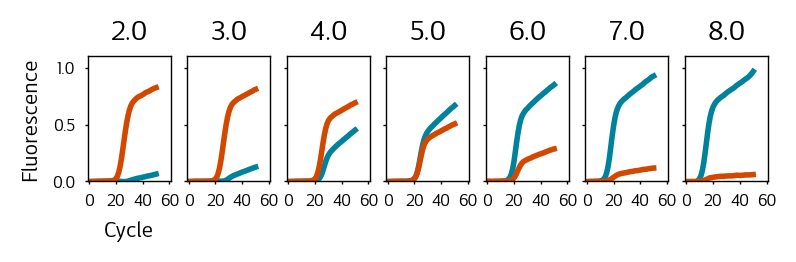

In [15]:
this = JG034.reactions.data[
    (JG034.reactions.data['Cycle'] <= cmax) &
    (JG034.reactions.data.Target.str.contains('GC55'))
]

wells = this.Well.unique()[::-2]

width = 3.80
height = 1.145

fig, axs = plt.subplots(1, len(wells), figsize = (width, height), sharey=True)

for well, ax in zip(wells, axs.flat):

    df = JG034.reactions.data[
        (JG034.reactions.data['Cycle'] <= cmax) &
        (JG034.reactions.data.Well == well)
    ]
    
    FAM = df[df.Target.str.contains('FAM')].Fluorescence.values
    HEX = df[df.Target.str.contains('HEX')].Fluorescence.values
    lg10_Copies = df.lg10_Copies.iloc[0]
    
    x = df.Cycle.unique()
    # ax.fill_between(x, FAM, HEX, color='0.7', alpha=0.5)
    ax.plot(x, FAM, lw=2, color=fam_color)
    ax.plot(x, HEX, lw=2, color=hex_color)
    
    y0 = HEX[-1]+0.05 if FAM[-1] > HEX[-1] else HEX[-1]-0.05
    y1 = FAM[-1]-HEX[-1]-0.125 if FAM[-1] > HEX[-1] else FAM[-1]-HEX[-1]+0.125
    # ax.arrow(x[-1], y0, 0, y1, color='k', head_width=3, head_length=0.1, length_includes_head=True, zorder=10)
    # Draw a dashed line from the arrow tip to the y-axis
    # ax.plot([x[-1], x[-1]], [0, min(HEX[-1], FAM[-1])-0.05], color='0.2', ls=':', lw=1, zorder=10)
    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-1, cmax+11)
    ax.set_xticks(np.arange(0, 61, 20))
    ax.set_title(f'{lg10_Copies:.1f}')
    format_ax(ax, figsize=(width, height), 
          mar_l=0.35,
          mar_r=0.05,
          mar_t=0.2,
          mar_b=0.32, 
          ticklabelsize=6, labelsize=8, titlesize=10)
    
axs[0].set_ylabel('Fluorescence')
axs[0].set_xlabel('Cycle')

panel = 'B'
subpanel = 'ii'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

## Response Profile

Saving Fig_1_B_iii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


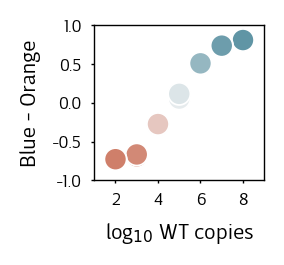

In [16]:
import seaborn as sns

endpoints = JG034.invert_fluorophore('HEX').extract_endpoints(name='FAM-HEX').invert_fluorophore('HEX')

width = 1.3
height = 1.145

this = JG034.endpoints[
    (JG034.endpoints.Target.str.contains('GC55'))
]

wells = this.Well.unique()[::2]

x_var = 'lg10_Copies'
hue = 'FAM-HEX'
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)

fig, ax = plt.subplots(1, 1, figsize = (width, height))
    
g = sns.scatterplot(data = this, x=x_var, y=hue, hue=hue, hue_norm=norm, palette=palette, 
                    s=spotsize, legend=False, ax=ax)

# spotsize **= 0.5
# ax.scatter(this[x_var], this[hue], cmap=palette, norm=norm, c=this[hue], s=spotsize)

ax.set_xlim(1, 9)
ax.set_ylim(-1, 1)
ax.set_xticks([2, 4, 6, 8])
ax.set_xlabel('log$_{10}$ WT copies')
ax.set_ylabel('Blue - Orange')
format_ax(ax, figsize=(width, height),
          mar_l=0.4,
          mar_r=0.05,
          mar_t=0.05,
          mar_b=0.32, 
          ticklabelsize=6, labelsize=8, titlesize=10)

panel = 'B'
subpanel = 'iii'

savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

# Reaction components

In [17]:
JG069J = (
    QuantStudio(data_pth / 'JG069J Final TB Experiment.xlsx', 'JG069J')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax, method='min-max')
    # .invert_fluorophore('HEX')
)

Saving Fig_1_C_i in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_D_i in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


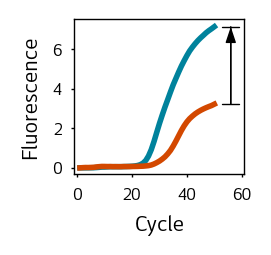

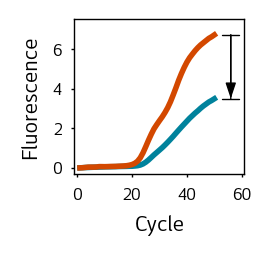

In [18]:
width = 1.3
height = 1.145

for i, well in enumerate([343, 115]):
    fig, ax = plt.subplots(1, 1, figsize = (width, height))

    df = JG069J.reactions.data[
        (JG069J.reactions.data['Cycle'] <= cmax) &
        (JG069J.reactions.data.Well == well)
    ]

    FAM = df[df.Target.str.contains('FAM')].Fluorescence.values*4
    FAM -= FAM[0]
    HEX = df[df.Target.str.contains('HEX')].Fluorescence.values*4
    HEX -= HEX[0]

    x = df.Cycle.unique()
    # ax.fill_between(x, FAM, HEX, color='0.7', alpha=0.5)
    ax.plot(x, FAM, lw=2, color=fam_color)
    ax.plot(x, HEX, lw=2, color=hex_color)
        
    x0 = x1 = x[-1]+6
    y0 = HEX[-1]
    y1 = FAM[-1]
    ax.annotate('', xytext=(x0, y0), xy=(x1, y1), color='k', 
                arrowprops=dict(arrowstyle="-|>", color='k', lw=0.5, shrinkA=0, shrinkB=0, mutation_scale=8, mutation_aspect=1.5))
    ax.annotate('', xytext=(x0, y0), xy=(x1, y1), color='k', 
                arrowprops=dict(arrowstyle="|-|", color='k', lw=0.5, shrinkA=0, shrinkB=0, mutation_scale=3))
    # Draw a dashed line from the arrow tip to the y-axis
    # ax.plot([x[-1], x[-1]], [0, min(HEX[-1], FAM[-1])-0.05], color='0.2', ls=':', lw=1, zorder=10)

    # ax.set_ylim(0, 1)
    ax.set_xlim(-1, cmax+11)
    ax.set_ylim(-0.33, 7.5)
    ax.set_xticks(np.arange(0, 61, 20))
    # ax.set_title(well)
    ax.tick_params(axis="both", length=2, labelsize=16)
        
    ax.set_ylabel('Fluorescence', fontsize=16)
    ax.set_xlabel('Cycle', fontsize=16);

    format_ax(ax, figsize=(width, height),
          mar_l=0.4,
          mar_r=0.05,
          mar_t=0.05,
          mar_b=0.32, 
          ticklabelsize=6, labelsize=8, titlesize=10)
        
    panel = ['C','D'][i]
    subpanel = 'i'
    
    savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')

Saving Fig_1_C_ii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_C_iii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_C_iv in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_D_ii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_D_iii in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done
Saving Fig_1_D_iv in /home/john/projects/CAN_paper/fig_1/graphics: [.svg] [.png] done


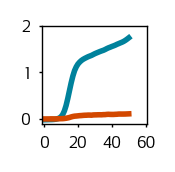

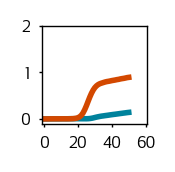

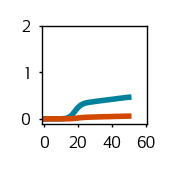

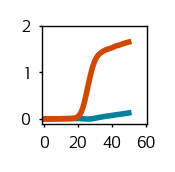

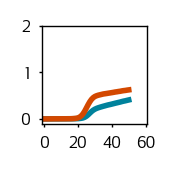

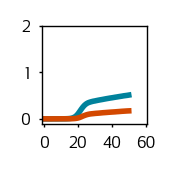

In [19]:
wells = this.Well.unique()[::-2]

dils = [[6, 1, 5],
        [0, 2, 4]]
weights = [[1.8, 1.1, 0.5],
           [2.0, 0.9, 0.6]]


width = 1.3 * 3/4
height = 1.145 * 3/4

# fig, axs = plt.subplots(2, 3, figsize = (width, height), sharey=True, sharex=True)

for row, (dil_row, weight_row) in enumerate(zip(dils, weights)):
    for col, (dil, weight) in enumerate(zip(dil_row, weight_row)):
        
        fig, ax = plt.subplots(1, 1, figsize = (width, height))

        well = wells[dil]
        
        df = JG034.reactions.data[
            (JG034.reactions.data['Cycle'] <= cmax) &
            (JG034.reactions.data.Well == well)
        ]
        
        FAM = df[df.Target.str.contains('FAM')].Fluorescence.values*weight
        HEX = df[df.Target.str.contains('HEX')].Fluorescence.values*weight
        lg10_Copies = df.lg10_Copies.iloc[0]
        
        x = df.Cycle.unique()
        # ax.fill_between(x, FAM, HEX, color='0.7', alpha=0.5)
        ax.plot(x, FAM, lw=2, color=fam_color)
        ax.plot(x, HEX, lw=2, color=hex_color)

        ax.set_ylim(-0.1, 2)
        ax.set_xlim(-1, 61)
        ax.set_yticks([0,1,2])
        ax.set_xticks([0, 20, 40, 60])
        format_ax(ax, figsize=(width, height),
            mar_l=0.4,
            mar_r=0.05,
            mar_t=0.05,
            mar_b=0.32, 
            ticklabelsize=6, labelsize=8, titlesize=10)
        
        panel = ['C','D'][row]
        subpanel = ['ii','iii','iv'][col]
        
        savefig(fig, f'Fig_{fig_num}_{panel}_{subpanel}')
    
